# Overview

In this attempt, I will use Resnet 50 along with other improvements made along the way of previous experiments.

## Load Data

Loading the data and splitting into train/val/test sets. Omitting details to keep it cleaner (please see previous notebooks for any detail explanation of these steps)

In [1]:
%load_ext autoreload
%autoreload 2

RANDOM_STATE = 2025

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

dataset_dir = "../data/cloth_dataset"
csv_file_name = "aarong_dataset_clean_final.csv"

# Load CSV File
csv_file = os.path.join(dataset_dir, csv_file_name)
df = pd.read_csv(csv_file)

single_label_features = ['fabric_types_clean', 'wear_types_clean']
multilabel_features = ['colors_clean', 'textures_clean', 'value_additions_clean']


# Remove rare labels
from my_utils.dataset_utils import remove_rare_labels

for column in single_label_features + multilabel_features:
	# Replace NaN values with empty strings
	df[column] = df[column].fillna('')

	# Remove rare labels
	df[column] = remove_rare_labels(df[column], min_samples_threshold=50)


# Encode labels
from my_utils.preprocessing_utils import ml_binarizer, onehot_encode

for column_name in single_label_features:
	df = onehot_encode(df, column_name)

for column_name in multilabel_features:
	df = ml_binarizer(df, column_name)


In [3]:
# Train/Val/Test Split in 70/15/15 ratio

from sklearn.model_selection import train_test_split

train_df, val_test_df = train_test_split(df, test_size=0.3, random_state=RANDOM_STATE)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=RANDOM_STATE)

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

from my_utils.CustomDataset import CustomMTLDataset
from torch.utils.data import DataLoader

train_ds = CustomMTLDataset(train_df, os.path.join(dataset_dir, 'images'), transform=transform)
val_ds = CustomMTLDataset(val_df, os.path.join(dataset_dir, 'images'), transform=transform)
test_ds = CustomMTLDataset(test_df, os.path.join(dataset_dir, 'images'), transform=transform)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True) 
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

---

## Model Definition

In [4]:
import torch.nn as nn
import torchvision.models as models

class MTLModelResnet50(nn.Module):
    def __init__(self, fabric_dim, wear_dim, color_dim, texture_dim, value_add_dim):
        super(MTLModelResnet50, self).__init__()
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.backbone.fc = nn.Identity()
        self.shared_dim = 2048  # Output of resnet50 without FC

        self.heads = nn.ModuleDict({
            'fabric': nn.Linear(self.shared_dim, fabric_dim),
            'wear': nn.Linear(self.shared_dim, wear_dim),
            'color': nn.Linear(self.shared_dim, color_dim),
            'texture': nn.Linear(self.shared_dim, texture_dim),
            'value_add': nn.Linear(self.shared_dim, value_add_dim),
        })

    def forward(self, x):
        features = self.backbone(x)
        return {task: head(features) for task, head in self.heads.items()}


## Training Setup

In [5]:
def calc_class_weights(dataloader, tasks):
    total_counts = {task: {'pos': None, 'neg': None} for task in tasks}
    
    for _, labels in dataloader:
        for task in tasks:
            # contains (batch_size, num_labels)
            label_tensor = labels[task]
            if total_counts[task]['pos'] is None:
                total_counts[task]['pos'] = label_tensor.sum(dim=0)
                total_counts[task]['neg'] = (1 - label_tensor).sum(dim=0)
            else:
                total_counts[task]['pos'] += label_tensor.sum(dim=0)
                total_counts[task]['neg'] += (1 - label_tensor).sum(dim=0)

    class_weights = {}
    for task in tasks:
        pos = total_counts[task]['pos']
        neg = total_counts[task]['neg']
        weight = neg / (pos + 1e-5)  # avoiding div by zero
        class_weights[task] = weight

	# returns Dict[str, Tensor] representing class weights for each task
    return class_weights

from my_utils.dataset_utils import get_all_labels

task_labels = {
	'fabric': get_all_labels(train_df['fabric_types_clean'], allow_empty=False),
	'wear': get_all_labels(train_df['wear_types_clean'], allow_empty=False),
	'color': get_all_labels(train_df['colors_clean'], allow_empty=False),
	'texture': get_all_labels(train_df['textures_clean'], allow_empty=True),
	'value_add': get_all_labels(train_df['value_additions_clean'], allow_empty=True),
}


In [6]:
import torch
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
from tqdm import tqdm
import json
import numpy as np

def run_epoch(model, loader, optimizer, device, is_train=True, threshold=0.5, class_weights=None):
	if is_train:
		model.train()
	else:
		model.eval()

	total_loss = 0.0
	total_unweighted_loss = 0.0

	all_preds = {k: [] for k in model.heads}
	all_targets = {k: [] for k in model.heads}

	for images, labels in tqdm(loader):
		images = images.to(device)
		labels = {k: v.to(device) for k, v in labels.items()}

		if is_train:
			optimizer.zero_grad()

		with torch.set_grad_enabled(is_train):
			outputs = model(images)
			losses = []
			unweighted_losses = []

			for task in outputs:
				unweighted_loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs[task], labels[task])

				if class_weights and task in class_weights:
					weights = class_weights[task].to(device)
					loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs[task], labels[task], weight=weights)
				else:
					loss = unweighted_loss
					
				losses.append(loss)
				unweighted_losses.append(unweighted_loss)

				if not is_train:
					probs = torch.sigmoid(outputs[task])
					preds = (probs > threshold).int()
					all_preds[task].extend(preds.cpu().numpy())
					all_targets[task].extend(labels[task].cpu().numpy())

			batch_loss = sum(losses)
			total_loss += batch_loss.item()

			total_unweighted_loss += (sum(unweighted_losses)).item()

			if is_train:
				batch_loss.backward()
				optimizer.step()

	avg_loss = total_loss / len(loader)
	avg_unweighted_loss = total_unweighted_loss / len(loader)

	if not is_train:
		metrics = {}

		for task in all_preds:
			# Class-wise metrics
			report = classification_report(all_targets[task], all_preds[task], target_names=task_labels[task], output_dict=True, zero_division=0)

			# Compute predicted support
			pred_counts = np.sum(np.array(all_preds[task]), axis=0)
			predicted_support = dict(zip(task_labels[task], pred_counts.tolist()))

			metrics[task] = {
				'f1': f1_score(all_targets[task], all_preds[task], average='micro', zero_division=0),
				'precision': precision_score(all_targets[task], all_preds[task], average='micro', zero_division=0),
				'recall': recall_score(all_targets[task], all_preds[task], average='micro', zero_division=0),
				'accuracy': accuracy_score(all_targets[task], all_preds[task]),

				'classwise_metrics':  {
					class_label : {
						'precision': report[class_label]['precision'],
						'recall': report[class_label]['recall'],
						'f1': report[class_label]['f1-score'],
						'support': report[class_label]['support'],
						'predicted_support': predicted_support[class_label],
					} for class_label in task_labels[task]
				}
			}

		return avg_loss, metrics
	
	else:
		return avg_loss, avg_unweighted_loss


def train_model(model, train_loader, val_loader, optimizer, device, num_epochs=10, threshold=0.5, use_class_weights=False, verbose=True, model_name=''):
	model.to(device)
	best_val_loss = float('inf')
	patience = 3
	patience_counter = 0

	if not model_name:
		model_name = model.__class__.__name__ + pd.Timestamp.now().strftime("%Y%m%d-%H%M%S")

	best_model_path = os.path.join('../data', 'model_weights', f'best_model-{model_name}.pt')
	history_path = os.path.join('../data', 'model_weights', f'history-{model_name}.json')

	history = {
		'train_loss': [],
		'unweighted_train_loss': [],
		'val_loss': [],
		'val_metrics': [],
		'best_epoch': 0
	}

	class_weights = calc_class_weights(train_loader, model.heads.keys()) if use_class_weights else None

	for epoch in range(num_epochs):
		print(f"\nEpoch {epoch+1}/{num_epochs}")
		train_loss, unweighted_train_loss = run_epoch(model, train_loader, optimizer, device, is_train=True, class_weights=class_weights)
		val_loss, val_metrics = run_epoch(model, val_loader, optimizer, device, is_train=False, threshold=threshold)

		history['train_loss'].append(train_loss)
		history['unweighted_train_loss'].append(unweighted_train_loss)
		history['val_loss'].append(val_loss)
		history['val_metrics'].append(val_metrics)

		print(f"Train Loss: {train_loss:.4f}")
		print(f"Val Loss: {val_loss:.4f}")

		if verbose:
			for task, task_metrics in val_metrics.items():
				print("Metrics for task:", task)
				for metric_name, metric_value in task_metrics.items():
					print(f"\t[Val {metric_name}]: {metric_value:.4f}")

		# Early stopping
		if val_loss < best_val_loss:
			best_val_loss = val_loss
			patience_counter = 0
			torch.save(model.state_dict(), best_model_path)
			history['best_epoch'] = epoch
		else:
			patience_counter += 1
			if patience_counter >= patience:
				print("Early stopping triggered.")
				break

	# Save the training history
	with open(history_path, 'w') as f:
		json.dump(history, f)
		
	return history


def evaluate_on_test(model, model_weight_path, test_loader, device, threshold=0.5, verbose=False):
	model.to(device)

	# Load saved weights
	model.load_state_dict(torch.load(model_weight_path, map_location=device))

	with torch.no_grad():
		test_loss, test_metrics = run_epoch(model=model, loader=test_loader, optimizer=None, device=device, is_train=False, threshold=threshold)

	if verbose:
		print(f"\nTest Set Performance:\nTest Loss: {test_loss:.4f}")
		for task, task_metrics in test_metrics.items():
			print(f"\nTask: {task}")
			for metric_name, value in task_metrics.items():
				if metric_name == 'f1':
					print(f"  {metric_name}: {value:.4f}")
			
	test_metric_path = os.path.join('../data', 'model_weights', f'test_metrics-{model_weight_path.split("/")[-1]}.json')

	with open(test_metric_path, 'w') as f:
		json.dump({'test_loss': test_loss, 'test_metrics': test_metrics}, f)
		
	return test_loss, test_metrics

## Training Run

In [8]:
model = MTLModelResnet50(
	fabric_dim=len(train_ds.label_columns['fabric']),
	wear_dim=len(train_ds.label_columns['wear']),
	color_dim=len(train_ds.label_columns['color']),
	texture_dim=len(train_ds.label_columns['texture']),
	value_add_dim=len(train_ds.label_columns['value_add']),
)

for param in model.backbone.parameters():
	param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=10,
    threshold=0.5,
	use_class_weights=True,
	verbose=False,
	model_name='resnet50_mtl_th0.5_cw'
)



Epoch 1/10


100%|██████████| 62/62 [00:04<00:00, 14.09it/s]


Train Loss: 14.5794
Val Loss: 1.5372

Epoch 2/10


100%|██████████| 62/62 [00:04<00:00, 13.81it/s]


Train Loss: 12.0721
Val Loss: 1.3067

Epoch 3/10


100%|██████████| 62/62 [00:04<00:00, 14.23it/s]


Train Loss: 10.8587
Val Loss: 1.2354

Epoch 4/10


100%|██████████| 62/62 [00:04<00:00, 13.65it/s]


Train Loss: 10.1714
Val Loss: 1.2261

Epoch 5/10


100%|██████████| 62/62 [00:04<00:00, 14.25it/s]


Train Loss: 9.3562
Val Loss: 1.1757

Epoch 6/10


100%|██████████| 62/62 [00:04<00:00, 14.03it/s]


Train Loss: 8.5960
Val Loss: 1.2232

Epoch 7/10


100%|██████████| 62/62 [00:04<00:00, 14.12it/s]


Train Loss: 7.6996
Val Loss: 1.2130

Epoch 8/10


100%|██████████| 62/62 [00:04<00:00, 14.35it/s]


Train Loss: 6.4776
Val Loss: 1.1795
Early stopping triggered.


## Evaluation

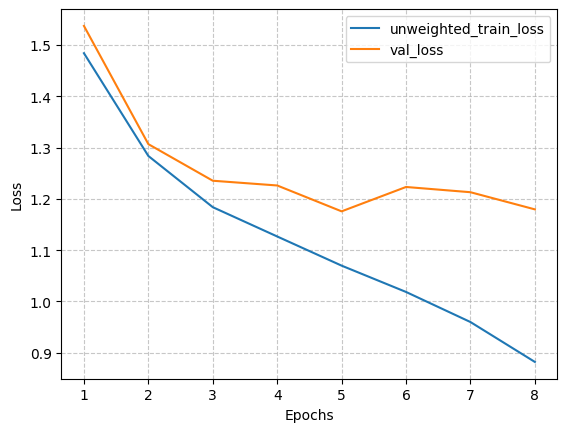

In [10]:
import matplotlib.pyplot as plt

from my_utils.plot_utils import plot_train_val_loss

plot_train_val_loss(history)

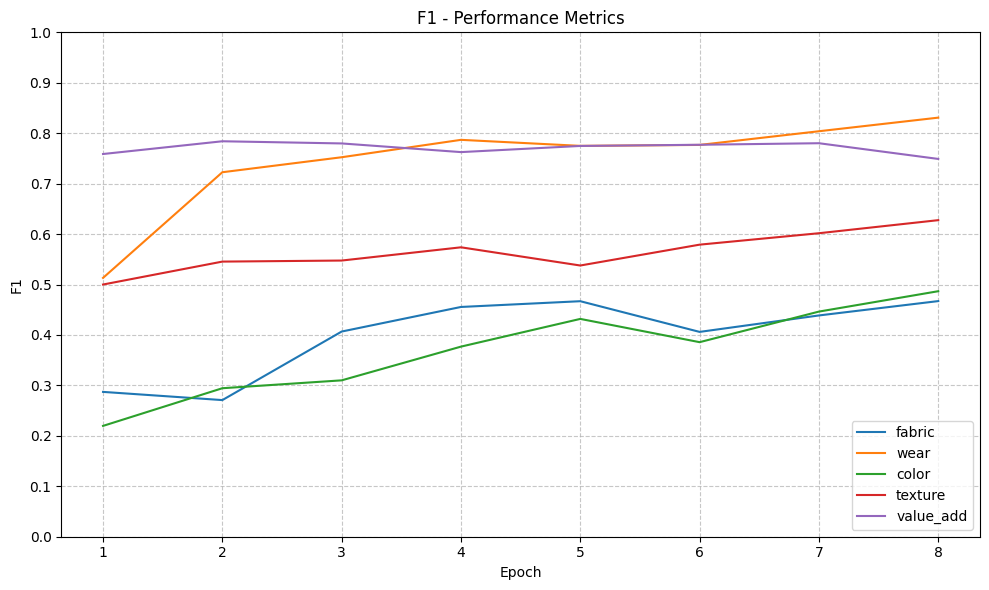

In [11]:
from my_utils.plot_utils import compare_tasks_for_metric

compare_tasks_for_metric(history, 'f1', show_losses=False)

In [14]:
from my_utils.eval_utils import parse_task_metrics
from IPython.display import display
from my_utils.eval_utils import load_task_metrics_for_test, compare_task_with_baseline
import pandas as pd

current_model_metrics, current_model_claswise_metrics = parse_task_metrics(history)
baseline_metrics, baseline_classwise_metrics = load_task_metrics_for_test('../data/model_weights/test_metrics-best_model-resnet18_baseline.pt.json')

compare_task_with_baseline(baseline_metrics, current_model_metrics, metrics=['f1', 'accuracy'], baseline_model_name='ResNet18', new_model_name='Resnet 50')

,Metric,Task,Baseline (ResNet18),Resnet 50,Delta
0,f1,fabric,0.48,0.47,-0.02
1,f1,wear,0.85,0.77,-0.07
2,f1,color,0.48,0.43,-0.05
3,f1,texture,0.58,0.54,-0.05
4,f1,value_add,0.73,0.77,0.05
5,accuracy,fabric,0.38,0.34,-0.04
6,accuracy,wear,0.79,0.69,-0.10
7,accuracy,color,0.09,0.06,-0.04
8,accuracy,texture,0.35,0.29,-0.05
9,accuracy,value_add,0.65,0.74,0.09
